### **Model Iterpretability( working of black box model ):**

*    Instead of predictions what if we tell what things has made that sample towards that class? This what model interpretability does.
It helps the humans to understand the processes involved to arrive at that outcome. 
*    It is something straight forward in case of Machine learning But what about deep learning?? <br>
Here we can make use of gradients which are learned throughout the training. larger the value of gradients indicates the higher activation at that point.
*    Model interpretability is highly essential in case of medical, banking problems. Because a wrong predictions can make a company at loss or may take a life of a person. 

**Working of Grad Cam:**<br>

<img src='https://i1.wp.com/www.hackevolve.com/wp-content/uploads/2018/02/gradcam.jpg?resize=1024%2C463'/>

**Step-1:** Takes an image and passes it to a model and takes the gradients with respect to each feature at particular convolutional layer(mostly last convolutional layer) also by making use of predicted class label.<br>
**Step-2:** Resizing the gradients to the size of the image.<br>
**Step3:** Plotting the heat map of that gradients to know the activations in predicting that class label with respect to the input image.<br>


<img src='https://imgur.com/Rhs27Rh.png'>

Where the cyan color indicates the higher activations in predicting the class (ball here).

Read more about Grad-Cam [here](http://www.hackevolve.com/where-cnn-is-looking-grad-cam/).


**Loading Dependencies:**

In [6]:
import os
os.chdir('/content/drive/My Drive/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import DenseNet121 
from keras.models import Sequential
import keras
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Activation, Flatten

**Loading the data:**

In [9]:
try:
    x_train = np.load("/content/drive/My Drive/processed_images/training.npy", mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_validation = np.load("/content/drive/My Drive/processed_images/validation.npy",mmap_mode=None, allow_pickle=False, fix_imports=True)
    x_test = np.load("/content/drive/My Drive/processed_images/test.npy", mmap_mode = None,allow_pickle = False, fix_imports = True)
    print("Loaded Successfully...\n")
    print(x_train.shape)
    print(x_validation.shape)
    print(x_test.shape)
except:
    print("file not exists")

Loaded Successfully...

(3112, 512, 512, 3)
(550, 512, 512, 3)
(1928, 512, 512, 3)


In [ ]:
train_labels = pd.read_csv('training.csv')
train_labels = train_labels['diagnosis']
validation_labels = pd.read_csv('validation.csv')
validation_labels = validation_labels['diagnosis']
print("Training:",train_labels.shape[0])
print("Validation:",validation_labels.shape[0])

Training: 3112
Validation: 550


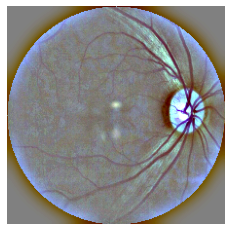

In [ ]:
plt.imshow(x_train[5])
plt.axis('off')
plt.show()

In [ ]:
### initialization
img_width = 512
img_height = 512
no_channels = 3

In [ ]:
def draw_circle(img):

    '''
    This function is used for drawing a circle from the center of the image.
    Arguments: img(np.array) - image for which we need to draw a circle.
    '''

    x = int(img_width/2)
    y = int(img_height/2)
    r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
    circle_img = np.zeros((img_height, img_width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    return img

In [ ]:
def test_prediction(predicted_labels):
    '''
    Making predictions of the probability scores. The class with more score will be taken as predicted class. 
    Arguments:
    predicted_labels - (np.array) - probability score of given sample
    '''
    predicted_labels = predicted_labels > 0.5
    prediction_ordinal = np.empty(predicted_labels.shape, dtype = int)
    prediction_ordinal[:,4] = predicted_labels[:,4]
    for i in range(3, -1, -1): prediction_ordinal[:, i] = np.logical_or(predicted_labels[:,i], prediction_ordinal[:,i+1])
    predicted_labels = prediction_ordinal.sum(axis = 1)-1
    return predicted_labels 

**DenseNet Architecture:**

In [ ]:
def DenseNet():
    '''This function is used for building a model architecture of pretrained Densenet121 on imagenet data set.'''
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(512,512,3))
    x = global_average_pooling_layer(densenet.layers[-1].output)
    x = dropout_layer(x)
    output = dense_layer(x)
    model = Model(densenet.layers[0].input,output)
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])
    return model
densenet = DenseNet()
densenet.load_weights("/content/drive/My Drive/models/densenet.h5")

### **Grad-Cam:**

In [ ]:
def plot_gradient_heatmap(model, img, layer_name = 'last_conv_layer'):
    '''
    This function is used to plot the gradients for model interpretability.
    Reference and code credits: http://www.hackevolve.com/where-cnn-is-looking-grad-cam/
    Arguments:
    model - trained model
    img - (np.array) - image data
    layer_name - (string) - layer from which we need to take gradients
    '''
    # model predictions
    preds = model.predict(img[np.newaxis])   # densenet model
    preds = preds_raw>0.5
    class_idx = (preds.astype(int).sum(axis=1)-1)[0]
    class_output_tensor = model.output[:,class_idx]

    # taking the output at particular convolutional layer
    layer_output = model.get_layer(layer_name)

    # taking gradients from model
    with tf.GradientTape() as tape:
        grads = model.predict(class_output_tensor, layer_output)[0]
    grads = tape.gradient(grads)[0]
    pooled_grads = K.mean(grads,axis=(0,1,2))
    iterate = K.function([model.input],[pooled_grads, layer_output.output[0]])
    pooled_grads, layer_output = iterate([img[np.newaxis]])
    for i in range(pooled_grads.shape[0]):
        layer_output[:,:,i] *= pooled_grads[i]

    # plotting heatmap
    heatmap = np.mean(layer_ouput, axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)     # normalizing the heatmap
    heatmap=cv2.resize(heatmap,(viz_img.shape[1],viz_img.shape[0]))  # resizing the image
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_SPRING)/255
    heated_img = heatmap_color*0.5 + viz_img*0.5
    return heated_img

**Plotting Interpretability:**

In [ ]:
def plot_interpretability(data,label):
    '''
    this function is used to plot the original, preprocessed image and gradients using grad-cam's
    Arguments:
    data - (np.array) - Image data
    label - (integer) - target class label
    '''
    def plot(row,col,index,img,title=None):
        ''' plotting individual images '''
        plt.subplot(row,col,index)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    count=0
    for i in range(3):   ### for each row (3 here)
        iter=0
        fig=plt.figure(figsize=(20,5))
        for j in range(2):   ### for each column (2 here)
            img = data[count]  ### image data
            plot(1,6,iter+1,img,str1.split('.')[0])  ### plotting original image
            iter+=1
            img_ = np.expand_dims(img,axis=0)
            pred = densenet.predict(img_)      ### predicting class label using densenet
            pred = test_prediction(pred)
            plot(1,6,iter+1,img,'Target Class: '+str(label))   ### plotting preprocessed image
            iter+=1
            img = plot_gradient_heatmap(densenet,img)      
            img = draw_circle(img)            ### drawing circle for better visualization
            plot(1,6,iter+1,img,'Predicted Class: '+str(pred))    ### plotting gradient plot
            iter+=1
            count+=1

### **Some of the Predictions of class-0 (No dr) from validation data:**

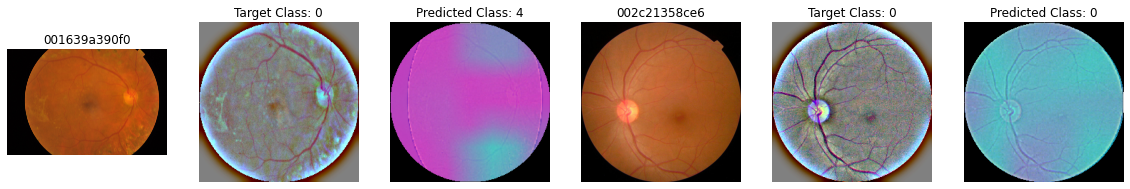

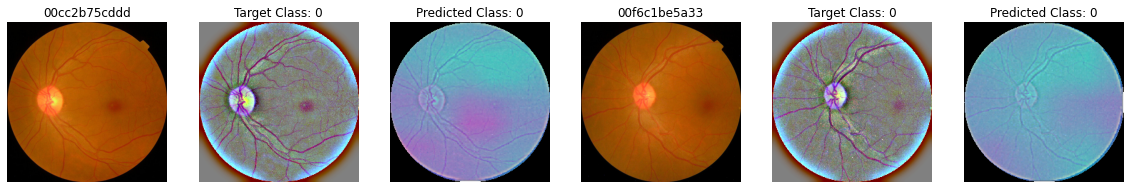

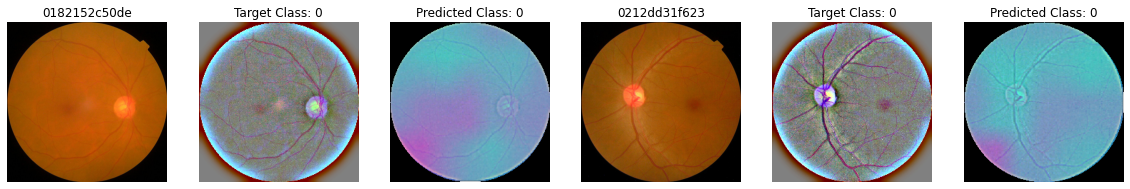

In [ ]:
N = 6
data = []
for i in range(len(validation_labels)):
    if validation_labels[i]==0: data.append(x_validation[i])
plot_interpretability(x_validation[:N],0)

>**Observations:**
*    For class-0 the model has high activations on all of the pixels.
*    The model is focusing mostly on the nerves and if there are no spots(cotton wounds, blood clots) it is predicting as 0.
*    For (0,0) model is predicting as class-4 and has high activations at the bottom right corner. But the actual prediction is 0.




**NOTE:**
Here I am filling the out of circled area with back pixels by drawing circle which we did in early preprocessing step so that it would be easy to see the activations with respect to preprocessed image.

<img src='https://imgur.com/rqBcNz5.png' width=400px height=150px/>

### **Some of the Predictions of Class-1 (Mild) from validation data:**

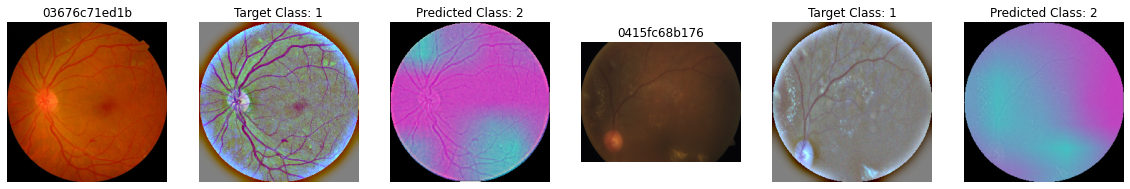

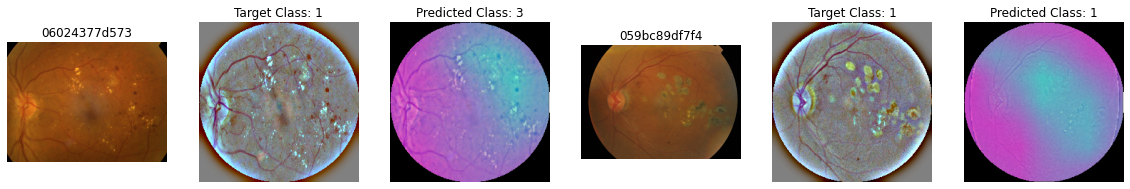

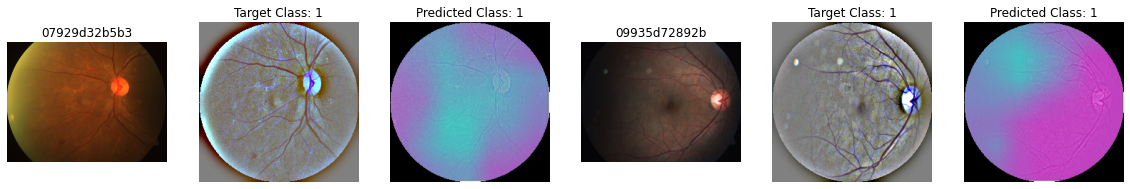

In [ ]:
N = 6
data = []
for i in range(len(validation_labels)):
    if validation_labels[i]==1: data.append(x_validation[i]) 
plot_interpretability(x_validation[:N],1) 

>**Observations:**
*    Model has high activations in the place of abnormal growth [(0,0), (2,1)] of nerves and exdates(fatty deposits)[(1,0), (1,1)] on the eye ball.
*    Model is toggled between predictions of class-1 and class-2.
*    More data of class-1 and class-2 in part of training can make the model to get distinguished between both of these classes.

### **Some of the predictions of Class-2 (Moderate) from validation data:**

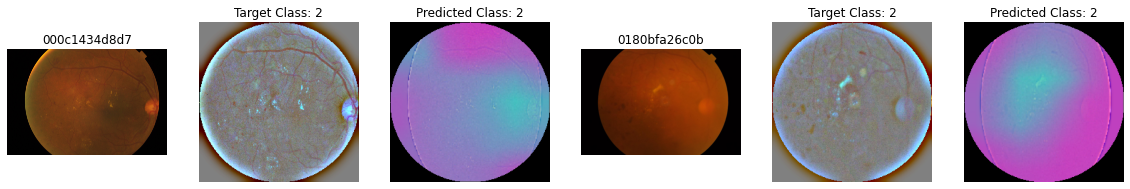

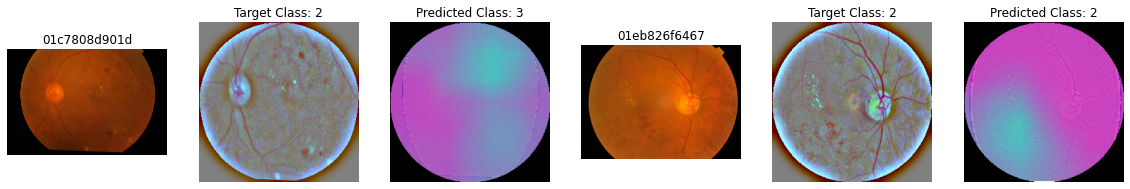

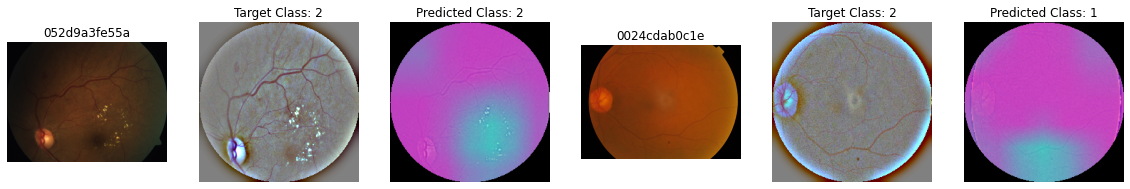

In [ ]:
N = 6
data = []
for i in range(len(validation_labels)):
    if validation_labels[i]==2: data.append(x_validation[i])
plot_interpretability(x_validation[:N],2)

>**Observations:**
*    In this class predictions, the model is focusing on small Hemorrhages(bleeding) [(0,1), (1,1)] and exudates [(1,1), (2,0)] formation in the eye ball.
*    It has high activations in the place of cotton wools.

### **Some of the Predictions of class-3 (Severe) from validation data:**

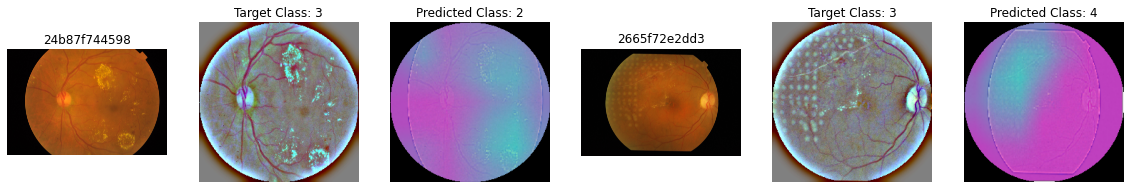

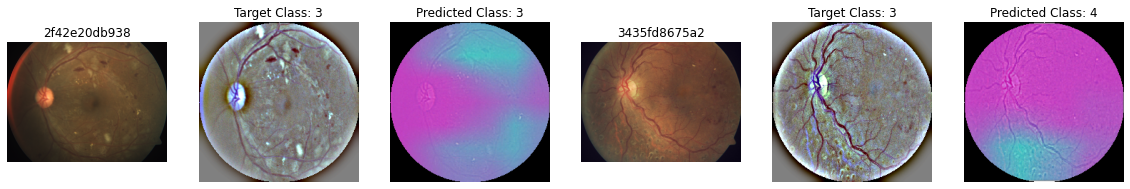

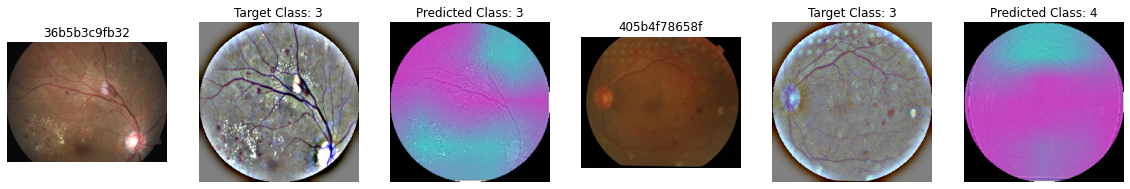

In [ ]:
N = 6
data = []
for i in range(len(validation_labels)):
    if validation_labels[i]==3: data.append(x_validation[i])
plot_interpretability(x_validation[:N],3)

>**Observations:**
*    It has high activations in place of hard excutes [(2,0)] and small cotton wools [(1,0)].
*    If they are in large number the model is predicting as 3 else 2.
*    The model is toggled between class-3 and 4 and anable to predict the correct class. 
*    More data can improve the class-3 predictions.

### **Some of the Predictions of class-4 (Proliferative DR) from validation data:**

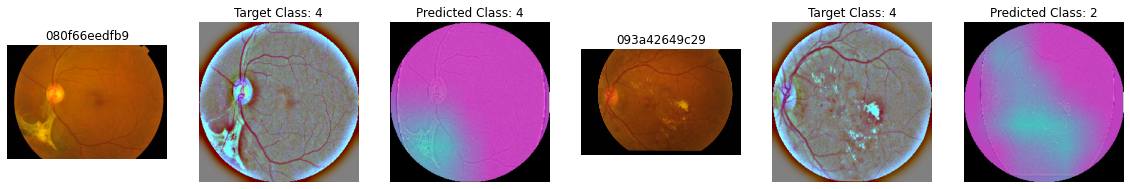

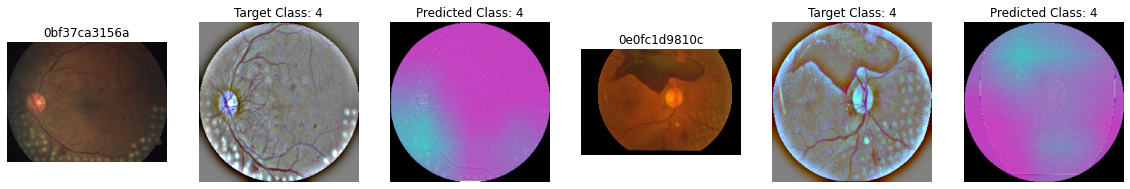

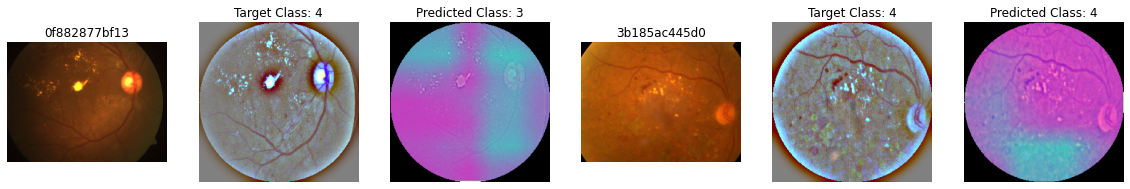

In [ ]:
N = 6
data = []
for i in range(len(validation_labels)):
    if validation_labels[i]==4: data.append(x_validation[i])
plot_interpretability(x_validation[:N],4)

>**Observations:**
*    In case of large cotton wools [(1,0), (1,1)] and hard excutes [(0,0) [1,1)] the model has high activation and predicting it has 4.
*    Basing on the severity and size, number of spots it is classifying the class.

### **Error Analysis:**

In [27]:
train = pd.read_csv('/content/drive/My Drive/training.csv')
train_ = list(train['diagnosis'])
train_idcode = list(train['id_code'])
train_predictions = list(pd.read_csv('/content/drive/My Drive/submission/train.csv')['densenet'])

validation = pd.read_csv('/content/drive/My Drive/validation.csv')
validation_ = list(validation['diagnosis'])
validation_idcode = list(validation['id_code'])
validation_predictions = list(pd.read_csv('/content/drive/My Drive/submission/validation.csv')['densenet'])

train_.extend(validation_)
train_predictions.extend(validation_predictions)

In [21]:
error_rate=[]
for i in range(5):
    false_preds=0
    for j in range(len(train_predictions)):
        if train_[j]==i and train_predictions[j]!=i:
            false_preds+=1
    error_rate.append(false_preds) 

<img src='https://imgur.com/dRV6RLC.png' width=600 height=300/>

In [28]:
for i in range(5):
    print("For class-{} the error rate is: {}".format(i,round((error_rate[i]/train_.count(i))*100,2)))

For class-0 the error rate is: 2.05
For class-1 the error rate is: 27.84
For class-2 the error rate is: 24.92
For class-3 the error rate is: 34.72
For class-4 the error rate is: 28.47


**Count of predictions which are less than the true predictions**

In [33]:
error_rate=[]
for i in range(5):
    false_preds=0
    for j in range(len(train_predictions)): 
        if train_[j]==i and train_predictions[j]!=i and train_predictions[j]<i: 
            false_preds+=1 
    error_rate.append(false_preds)

<img src='https://imgur.com/eMHOJwt.png' width=600 height=300/>

>Here 10 samples actually belongs to class-1 but predicted as class-0. These 10 cases are the most important to examine because these patient actually have retinopathy(mild stage) but predicted as having No retinopathy.

In [28]:
index=[]
for j in range(len(train_predictions)): 
    if train_[j]==1 and train_predictions[j]==0: 
        index.append(j)
x = np.append(x_train,x_validation,axis=0)
idcode = np.append(train_idcode,validation_idcode)

These are the 10 samples whose actual prediction is 1 but predicted as 0


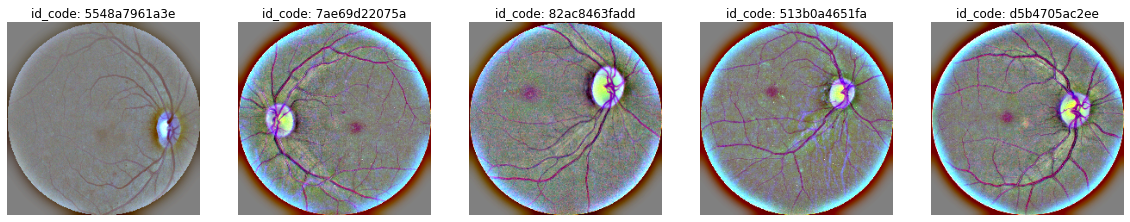

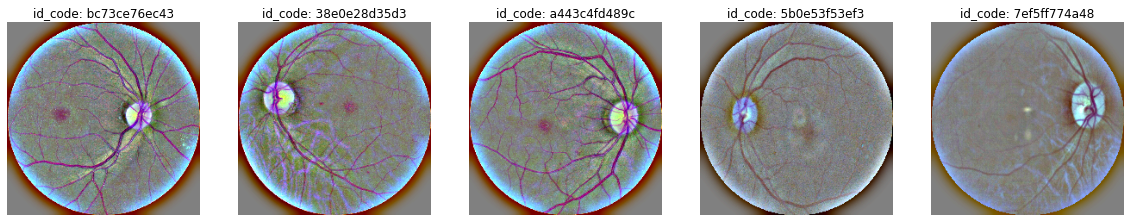

In [32]:
print("These are the 10 samples whose actual prediction is 1 but predicted as 0")
iter=0
for i in range(2):
    plt.figure(figsize=(20,5))
    for j in range(0,5):
        plt.subplot(1,5,j+1)
        plt.imshow(x[index[iter]])
        plt.title("id_code: "+idcode[index[iter]])
        plt.axis('off')
        iter+=1
    plt.show()

>## **Overall Observations of the case study:**
*   We can see their is high rate of misclassification among class-2 an class-3.
*    More sample data on training can improve the performance on these classes.
*    More preprocessing and with different sigmax (low than the actual) can be useful in predictions.
*    Their is high chance of data shrinkage on square crop images. Hence we need to come up with different approach (manual cropping is best).
*    Drawing circle on the images has made all the samples to be equal and also helped in interpretation of model predictions. Partially Resolved the problem of over expose and under expose.
*    Ensembles has worked best in our case. But it loses the property of interpretability.
*    Advanced pretrained models on complex datasets especially trained on medical(eye) can fairly improve our model.
*   Need to come up with differet augmentaion techniques to increase the size of the data set.


**The final solution to our problem statement:**

*    After applying a couple of pretrained models, Ensembling those models has given a top score of 0.9314.
*    But here our goal is not only to give the best score but to provide a system that makes a prediction with an explanation. 
*    Here I have chosen DenseNet which has given the next best score of 0.923 val kappa score for model interpretability and ensemble of all pretrained models for final model prediction.

<img src='https://cdn-images-1.medium.com/max/1800/1*Avr09iLbIG4XLYLTUBmsZA.png'>